In [1]:
import pandas as pd
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import nltk
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from joblib import dump

In [2]:
data = pd.read_csv("airline_sentiment_analysis.csv")
data.head()

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


## Basic Stats

In [3]:
print("Number of rows : ",data.shape[0])
print("Number of columns : ", data.shape[1])

Number of rows :  11541
Number of columns :  3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         11541 non-null  int64 
 1   airline_sentiment  11541 non-null  object
 2   text               11541 non-null  object
dtypes: int64(1), object(2)
memory usage: 270.6+ KB


In [6]:
data.airline_sentiment.value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

## Data cleaning and preprocessing

In [8]:
text = data["text"][1]
text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

In [9]:
# https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
cleantext = BeautifulSoup(text, "lxml").text
cleantext

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse'

In [10]:
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
cleantext = re.sub(r'[^\w\s]','',cleantext)
cleantext

'VirginAmerica its really aggressive to blast obnoxious entertainment in your guests faces  they have little recourse'

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
cleantext= cleantext.lower()
stopword = set(stopwords.words('english'))
tokens= cleantext.split()
token_list = []
for token in tokens:
    if token not in stopword:
        token_list.append(token)
     


In [14]:
stopword = set(stopwords.words('english'))

In [15]:

token_list

['virginamerica',
 'really',
 'aggressive',
 'blast',
 'obnoxious',
 'entertainment',
 'guests',
 'faces',
 'little',
 'recourse']

In [16]:
lemmatizer = WordNetLemmatizer()

In [24]:
lemmatizer.lemmatize("books")

'book'

In [23]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...


True

In [22]:
[lemmatizer.lemmatize(token) for token in token_list]

['virginamerica',
 'really',
 'aggressive',
 'blast',
 'obnoxious',
 'entertainment',
 'guest',
 'face',
 'little',
 'recourse']

In [21]:
import nltk
nltk.download('omw-1.4')
  

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...


True

In [25]:
lemma_word = []
for token in token_list:
    lemma_word.append(lemmatizer.lemmatize(token))
lemma_word

['virginamerica',
 'really',
 'aggressive',
 'blast',
 'obnoxious',
 'entertainment',
 'guest',
 'face',
 'little',
 'recourse']

In [26]:
join_text = ' '.join(lemma_word)
join_text

'virginamerica really aggressive blast obnoxious entertainment guest face little recourse'

In [27]:
def data_cleaner(data):
    clean_data = []
    for sentence in tqdm(data):
        cleantext = BeautifulSoup(sentence, "lxml").text #html tags
        cleantext = re.sub(r'[^\w\s]','',cleantext) # punctuation
        cleantext = [token for token in cleantext.lower().split() if token not in stopword] #stopword
        clean_text = ' '.join([lemmatizer.lemmatize(token) for token in cleantext])
        clean_data.append(clean_text.strip())
    return clean_data

In [30]:
clean_data = data_cleaner(data.text.values)

100%|██████████████████████████████████████████████████████████████████████████| 11541/11541 [00:03<00:00, 3353.44it/s]


In [31]:
clean_data[100]

'virginamerica dont understand need dm give answer damaged luggage policy'

## train test split

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data.airline_sentiment, test_size=0.2, random_state=42 ,stratify=data["airline_sentiment"])

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [41]:
le1 = LabelEncoder()
y_test = le1.fit_transform(y_test)

In [42]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9232, 3) (9232,)
(2309, 3) (2309,)


In [44]:
clean_data_train_data = data_cleaner(X_train.text.values)

100%|████████████████████████████████████████████████████████████████████████████| 9232/9232 [00:02<00:00, 3361.29it/s]


In [45]:
X_train = X_train.reset_index(drop=True)
X_train['cleaned_text'] = clean_data_train_data
X_train.head()

,Unnamed: 0,airline_sentiment,text,cleaned_text
0,8442,negative,@JetBlue Finally starting to come out. 40 minu...,jetblue finally starting come 40 minute commun...
1,9096,negative,@USAirways oh I got right through to an agent....,usairways oh got right agent kept putting hold...
2,12015,negative,@AmericanAir any idea on what the wait time is...,americanair idea wait time refund usairways to...
3,13289,negative,@AmericanAir Priority baggage evidently means ...,americanair priority baggage evidently mean co...
4,9716,negative,@USAirways you're really fudgin up with all th...,usairways youre really fudgin delay justwantmybed


In [47]:
clean_data_test_data =  data_cleaner(X_test.text.values)

100%|████████████████████████████████████████████████████████████████████████████| 2309/2309 [00:00<00:00, 3284.34it/s]


In [48]:
X_test = X_test.reset_index(drop=True)
X_test['cleaned_text'] = clean_data_test_data
X_test.head()

,Unnamed: 0,airline_sentiment,text,cleaned_text
0,11451,negative,@USAirways your agent did not say,usairways agent say
1,1985,negative,@united overbooked by FIFTY people?!? the worst.,united overbooked fifty people worst
2,1357,negative,@united … But friendly efficient air attendant...,united friendly efficient air attendant coach ...
3,2128,negative,@united considering I'm now stuck in Newark wi...,united considering im stuck newark virtually s...
4,11250,negative,@USAirways this has been the worst trip with l...,usairways worst trip little customer service


## Vectorizer

In [49]:
vec = CountVectorizer()
vec.fit(X_train.cleaned_text)
train_x_bow = vec.transform(X_train.cleaned_text)
test_x_bow = vec.transform(X_test.cleaned_text)

In [50]:
print(train_x_bow.shape)
print(test_x_bow.shape)

(9232, 11341)
(2309, 11341)


## Naive Bayes with Hyperparameter tuning

In [51]:
classfier = MultinomialNB()

In [52]:
alpha_ranges = {"alpha":[10**-2,10**-1,10**0,10**1,10**2]}
grid_search =GridSearchCV(classfier , param_grid = alpha_ranges ,scoring= "accuracy",cv=3,return_train_score = True)
grid_search.fit(train_x_bow,y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='accuracy')

In [53]:
alpha = [10**-2,10**-1,10**0,10**1,10**2]
train_acc = grid_search.cv_results_['mean_train_score']
train_std = grid_search.cv_results_['std_train_score']
test_acc = grid_search.cv_results_['mean_test_score']
test_std = grid_search.cv_results_['std_test_score']

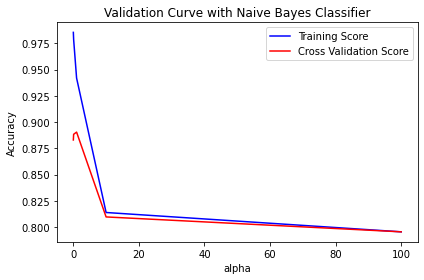

In [54]:
# https://www.geeksforgeeks.org/validation-curve/
# Plot mean accuracy scores for training and testing scores
plt.plot(alpha, train_acc,
     label = "Training Score", color = 'b')
plt.plot(alpha, test_acc,
   label = "Cross Validation Score", color = 'r')
 
# Creating the plot
plt.title("Validation Curve with Naive Bayes Classifier")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [55]:
grid_search.best_estimator_

MultinomialNB(alpha=1)

In [56]:
classifier = MultinomialNB(alpha=1)
classifier.fit(train_x_bow,y_train)

MultinomialNB(alpha=1)

In [57]:
predict = classifier.predict(test_x_bow)

In [58]:
print("accuracy is :",accuracy_score(y_test,predict))

accuracy is : 0.8977912516240797


In [59]:
print("accuracy is :",classification_report(y_test,predict))

accuracy is :               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1836
           1       0.87      0.59      0.70       473

    accuracy                           0.90      2309
   macro avg       0.89      0.78      0.82      2309
weighted avg       0.90      0.90      0.89      2309



In [60]:
dump(vec,"vectors.joblib")
dump(classifier,"model.joblib")

['model.joblib']